In [ ]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [402]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import *
from event_clustering.feature_engineering import *

from sklearn.cluster import *
import sklearn.metrics as metrics

# Loading Preprocessing Analyzing

In [379]:
file_path = 'data/DomesticDeclarations.xes'
df = preprocess(load(file_path))

In [380]:
analyze(df)
df.head(10)

column name: case:Amount
data type: <class 'numpy.float64'>
unqiue values: 8326


column name: case:BudgetNumber
data type: <class 'str'>
unqiue values: 1


column name: case:DeclarationNumber
data type: <class 'str'>
unqiue values: 10049


column name: case:concept:name
data type: <class 'str'>
unqiue values: 10500


column name: case:id
data type: <class 'str'>
unqiue values: 10500


column name: concept:name
data type: <class 'str'>
unqiue values: 17


column name: id
data type: <class 'str'>
unqiue values: 56437


column name: org:resource
data type: <class 'str'>
unqiue values: 2


column name: org:role
data type: <class 'str'>
unqiue values: 7


column name: time:timestamp
data type: <class 'datetime.datetime'>
unqiue values: 45403




,case:Amount,case:BudgetNumber,case:DeclarationNumber,case:concept:name,case:id,concept:name,id,org:resource,org:role,time:timestamp
0,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration SUBMITTED by EMPLOYEE,st_step 86794_0,STAFF MEMBER,EMPLOYEE,2017-01-09 09:49:50+01:00
1,182.464172,budget 86566,declaration number 86796,declaration 86795,declaration 86795,Declaration SUBMITTED by EMPLOYEE,st_step 86798_0,STAFF MEMBER,EMPLOYEE,2017-01-09 10:26:14+01:00
2,320.646137,budget 86566,declaration number 86801,declaration 86800,declaration 86800,Declaration SUBMITTED by EMPLOYEE,st_step 86804_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:13:33+01:00
3,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration SUBMITTED by EMPLOYEE,st_step 86733_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:24:20+01:00
4,26.851205,budget 86566,declaration number 86792,declaration 86791,declaration 86791,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86793_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:27:48+01:00
5,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration SUBMITTED by EMPLOYEE,st_step 86738_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:30:26+01:00
6,134.404169,budget 86566,declaration number 86736,declaration 86735,declaration 86735,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86737_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:18+01:00
7,113.862047,budget 86566,declaration number 86732,declaration 86731,declaration 86731,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86734_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:37:23+01:00
8,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration SUBMITTED by EMPLOYEE,st_step 86807_0,STAFF MEMBER,EMPLOYEE,2017-01-09 11:40:47+01:00
9,443.585163,budget 86566,declaration number 86806,declaration 86805,declaration 86805,Declaration FINAL_APPROVED by SUPERVISOR,st_step 86808_0,STAFF MEMBER,SUPERVISOR,2017-01-09 11:41:23+01:00


# Feature Generation

In [382]:
# add_previous_and_next_event_name(df)

In [383]:
add_timestamp_features(df)

# Encoding

In [384]:
df_cn = tfidf_encode(df, 'concept:name', TfidfVectorizer(stop_words = 'english'))
df_role = one_hot_encode(df, 'org:role')

In [396]:
df_vectorized = df_cn
df_vectorized = df_vectorized.join(df_role)
#df_vectorized = df_vectorized.join(df['feature_day_nr'])

# Clustering + Evaluation

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters


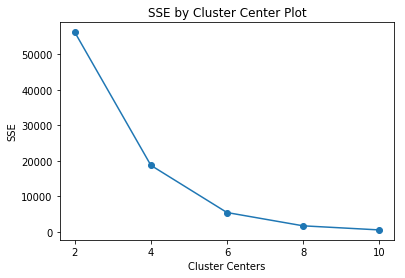

In [397]:
find_optimal_clusters(df_vectorized, 10)

In [398]:
clusters = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, random_state=20).fit_predict(df_vectorized)

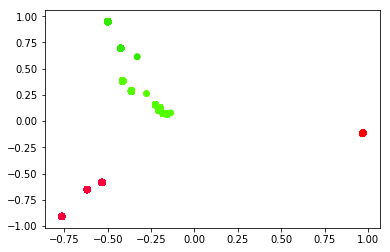

In [403]:
plot_pca(df_vectorized, clusters)

In [395]:
metrics.silhouette_score(df_vectorized, clusters)

0.6055779180944255
